In [1]:
%matplotlib widget
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

In [24]:
dataH1 = pd.read_csv("GBPUSD_H1.csv")
dataH1['Time'] = pd.to_datetime(dataH1['Time'])

dataM1 = pd.read_csv("GBPUSD_M1.csv")
dataM1['Time'] = pd.to_datetime(dataM1['Time'])


c:\Users\Admin\miniconda3\envs\machine-learning-env\lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0.8091236466534866 %


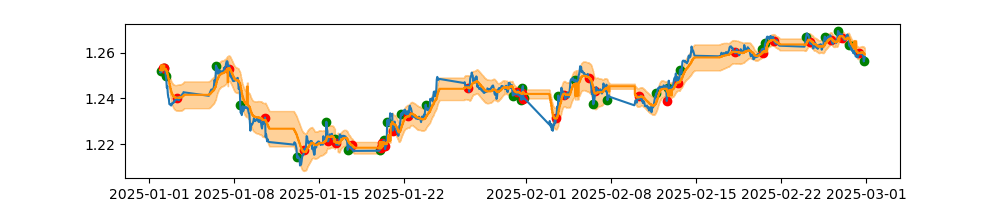

In [ ]:
min_price = dataM1['Close'].values
min_times = dataM1['Time'].values.astype('datetime64[ms]')

hour_close = dataH1['Close'].values
hour_open = dataH1['Open'].values
hour_times = dataH1['Time'].values

study_start = np.datetime64("2025-01-01T05:00")
study_end = np.datetime64("2025-03-01T05:00")

min_indices = np.arange(np.searchsorted(min_times, study_start), np.searchsorted(min_times, study_end))
hour_indices = np.arange(np.searchsorted(hour_times, study_start), np.searchsorted(hour_times, study_end))



fig, axs = plt.subplots(1,1, figsize=(10,2))
#axs.scatter(min_times[min_indices], min_price[min_indices], s=1)
axs.plot(hour_times[hour_indices], hour_open[hour_indices])

window_size = 100

kernel = Matern(length_scale=1.0, nu=1.5, length_scale_bounds=(1e-3, 1e6))
gpr = GaussianProcessRegressor(kernel=kernel, alpha= 2, n_restarts_optimizer=1, normalize_y=True)

y_preds = np.empty(len(hour_indices))
std_preds = np.empty(len(hour_indices))

for i in range(len(hour_indices)):
    current_index = hour_indices[i]

    X = np.arange(window_size)[:, None]
    y = hour_close[current_index-window_size:current_index].reshape(-1,1)

    gpr.fit(X, y)
    y_pred, std = gpr.predict([X[-1]], return_std=True)
    y_preds[i] = y_pred.item()
    std_preds[i] = std.item()

time_preds = hour_times[hour_indices]
ucb = y_preds + 1.96 * std_preds
lcb = y_preds - 1.96 * std_preds
plt.fill_between(time_preds, lcb, ucb, alpha=0.4, color='darkorange', step='post')
axs.step(time_preds, y_preds, color='darkorange', where='post')

#evaluate

#print("Analyzing...")

current_pos = 'none'
buys = []
buys_times = []
sells = []
sells_times = []
buys_closes = []
buys_closes_times = []
sells_closes = []
sells_closes_times = []

delta=0

for i in range(len(hour_indices)):
    current_index = hour_indices[i]

    if (current_pos == 'none'):

        if (hour_open[current_index] <= lcb[i]):
            current_pos = 'buy'
            buys.append(hour_open[current_index])
            buys_times.append(hour_times[current_index])

        if (hour_open[current_index] >= ucb[i]):
            current_pos = 'sell'
            sells.append(hour_open[current_index])
            sells_times.append(hour_times[current_index])

    if (current_pos == 'buy'):

        if (hour_open[current_index] >= y_preds[i]):
            current_pos = 'none'
            buys_closes.append(hour_open[current_index])
            buys_closes_times.append(hour_times[current_index])

            profit = (buys_closes[-1]-buys[-1])/buys[-1]
            delta += profit
            #print("Closed buy: ", profit*100, "%")

    if (current_pos == 'sell'):

        if (hour_open[current_index] <= y_preds[i]):
            current_pos = 'none'
            sells_closes.append(hour_open[current_index])
            sells_closes_times.append(hour_times[current_index])
            profit = -(sells_closes[-1]-sells[-1])/sells[-1]
            delta += profit
            #print("Closed sell: ", profit*100, "%")


axs.scatter(buys_times, buys, color='green')
axs.scatter(sells_times, sells, color = 'green')
axs.scatter(buys_closes_times, buys_closes, color='red')
axs.scatter(sells_closes_times, sells_closes, color='red')

print(delta*100, "%")